# Segmentation: KNN

In this notebook we demonstrate segmenting an image using KNN with ground truth data as the training set.

Steps:
1. Training KNN Classifier
 - load and convert ground truth data to contours
 - load image and convert to reflectance
 - use contours to get crop / non-crop pixels
 - use crop / non-crop pixels as knn train  
2. Testing KNN Classifier
 - predict crop / non-crop pixels on same image
 - predict crop / non-crop pixels on train image

In [1]:
from collections import namedtuple
import copy
from functools import partial
import json
import os

import cv2
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pyproj
import rasterio
from shapely.geometry import mapping, shape
from shapely.ops import transform
from sklearn import neighbors

%matplotlib inline

## Training Classifier

### Input Data

In [2]:
data_folder = os.path.join('data', 'train')

# # Created in datasets-identify notebook
# train_pl_metadata_filename = os.path.join(data_folder, '20160831_180231_0e0e_3B_AnalyticMS_metadata.xml')
# assert os.path.isfile(train_pl_metadata_filename)

# Created in datasets-prepare notebook
train_pl_filename = os.path.join(data_folder, '20160831_180231_0e0e_3B_AnalyticMS_cropped.tif')
assert os.path.isfile(train_pl_filename)

train_ground_truth_filename = os.path.join(data_folder, 'ground-truth_cropped.geojson')
assert os.path.isfile(train_ground_truth_filename)

### Features to Contours

In [3]:
# Utility functions: features to contours

def project_feature(feature, proj_fcn):
    """Creates a projected copy of the feature.
    
    :param feature: geojson description of feature to be projected
    :param proj_fcn: partial function defining projection transform"""
    g1 = shape(feature['geometry'])
    g2 = transform(proj_fcn, g1)
    proj_feat = copy.deepcopy(feature)
    proj_feat['geometry'] = mapping(g2)
    return proj_feat


def project_features(features, img_srs, src_srs='epsg:4326'):
    """Project features to img_srs.
    
    If src_srs is not specified, WGS84 (only geojson-supported crs) is assumed.
    
    :param features: list of geojson features to be projected
    :param str img_srs: destination spatial reference system
    :param str src_srs: source spatial reference system
    """
    # define projection
    # from shapely [docs](http://toblerity.org/shapely/manual.html#shapely.ops.transform)
    proj_fcn = partial(
        pyproj.transform,
        pyproj.Proj(init=src_srs),
        pyproj.Proj(init=img_srs))
    
    return [project_feature(f, proj_fcn) for f in features]


def polygon_to_contour(feature_geometry, image_transform):
    """Convert the exterior ring of a geojson Polygon feature to an
    OpenCV contour.
    
    image_transform is typically obtained from `img.transform` where 
    img is obtained from `rasterio.open()
    
    :param feature_geometry: the 'geometry' entry in a geojson feature
    :param rasterio.Affine image_transform: image transformation"""
    points_xy = shape(feature_geometry).exterior.coords
    points_x, points_y = zip(*points_xy) # inverse of zip
    rows, cols = rasterio.transform.rowcol(image_transform, points_x, points_y)
    return np.array([pnt for pnt in zip(cols, rows)], dtype=np.int32)

In [4]:
def load_geojson(filename):
    with open(filename, 'r') as f:
        return json.load(f)

In [5]:
def load_contours(ground_truth_filename, pl_filename):
    with rasterio.open(pl_filename) as img:
        img_transform = img.transform
        img_srs = img.crs['init']

    ground_truth_data = load_geojson(ground_truth_filename)

    # project to image srs
    projected_features = project_features(ground_truth_data, img_srs)

    # convert projected features to contours
    contours = [polygon_to_contour(f['geometry'], img_transform)
                for f in projected_features]
    return contours

print(len(load_contours(train_ground_truth_filename, train_pl_filename)))

223


### Visualize Contours over Image

In [6]:
# Utility functions: loading an image

NamedBands = namedtuple('NamedBands', 'b, g, r, nir')

def load_bands(filename):
    """Loads a 4-band BGRNir Planet Image file as a list of masked bands.
    
    The masked bands share the same mask, so editing one band mask will
    edit them all."""
    with rasterio.open(filename) as src:
        b, g, r, nir = src.read()
        mask = src.read_masks(1) == 0 # 0 value means the pixel is masked
    
    bands = NamedBands(b=b, g=g, r=r, nir=nir)
    return NamedBands(*[np.ma.array(b, mask=mask)
                        for b in bands])

def get_rgb(named_bands):
    return [named_bands.r, named_bands.g, named_bands.b]

def check_mask(band):
    return '{}/{} masked'.format(band.mask.sum(), band.mask.size)
    
print(check_mask(load_bands(train_pl_filename).r))

74018/2366366 masked


In [7]:
# Utility functions: displaying an image

def _linear_scale(ndarray, old_min, old_max, new_min, new_max):
    """Linear scale from old_min to new_min, old_max to new_max.
    
    Values below min/max are allowed in input and output.
    Min/Max values are two data points that are used in the linear scaling.
    """
    #https://en.wikipedia.org/wiki/Normalization_(image_processing)
    return (ndarray - old_min)*(new_max - new_min)/(old_max - old_min) + new_min
# print(linear_scale(np.array([1,2,10,100,256,2560, 2660]), 2, 2560, 0, 256))

def _mask_to_alpha(bands):
#     band = np.atleast_3d(bands)[...,0]
    band = np.atleast_3d(bands[0])
    alpha = np.zeros_like(band)
    alpha[~band.mask] = 1
    return alpha

def _add_alpha_mask(bands):
    return np.dstack([bands, _mask_to_alpha(bands)])

def bands_to_display(bands, alpha=False):
    """Converts a list of 3 bands to a 3-band rgb, normalized array for display."""  
    assert len(bands) in [1,3]
    all_bands = np.dstack(bands)
    old_min = np.percentile(all_bands, 2)
    old_max = np.percentile(all_bands, 98)

    new_min = 0
    new_max = 1
    scaled = [np.clip(_linear_scale(b.astype(np.double),
                                    old_min, old_max, new_min, new_max),
                      new_min, new_max)
              for b in bands]

    filled = [b.filled(fill_value=new_min) for b in scaled]
    if alpha:
        filled.append(_mask_to_alpha(scaled))

    return np.dstack(filled)

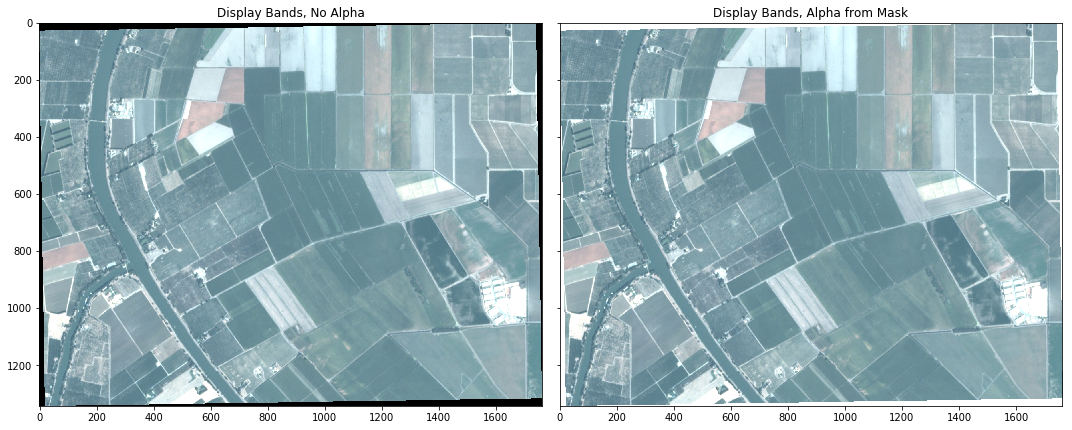

In [99]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, figsize=(15,15))
for ax in (ax1, ax2):
    ax.set_adjustable('box-forced')

ax1.imshow(bands_to_display(get_rgb(load_bands(train_pl_filename)), alpha=False))
ax1.set_title('Display Bands, No Alpha')

ax2.imshow(bands_to_display(get_rgb(load_bands(train_pl_filename)), alpha=True))
ax2.set_title('Display Bands, Alpha from Mask')
plt.tight_layout()

In [97]:
# Utility functions: displaying contours

def draw_contours(img, contours, color=(0, 1, 0), thickness=2):
    """Draw contours over a copy of the image"""
    n_img = img.copy()
    cv2.drawContours(n_img,contours,-1,color,thickness=thickness)
    return n_img

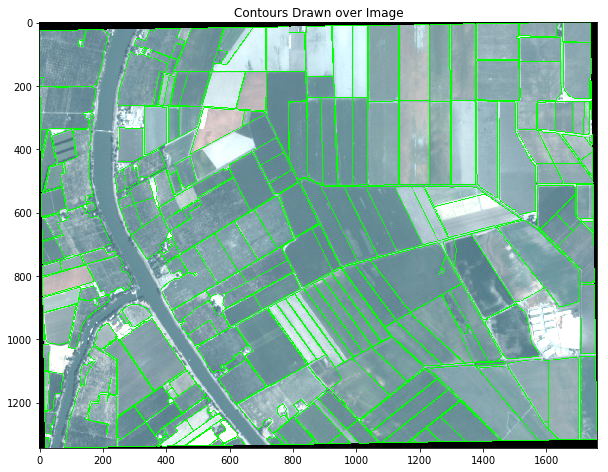

In [98]:
plt.figure(1, figsize=(10,10))
plt.imshow(draw_contours(bands_to_display(get_rgb(load_bands(train_pl_filename)), alpha=False),
                         load_contours(train_ground_truth_filename, train_pl_filename)))
plt.title('Contours Drawn over Image')

## Separate Crop and Non-Crop Pixels

To train the knn classifier, we need to separate crop from non-crop pixels. We will do this by using the crop feature contours to mask the crop or non-crop pixels.

In [11]:
# Utility functions: masking pixels using contours

def _create_contour_mask(contours, shape):
    """Masks out all pixels that are not within a contour"""
    mask = np.zeros(shape, dtype=np.uint8)
    cv2.drawContours(mask, contours, -1, (1), thickness=-1)
    return mask < 1

def combine_masks(masks):
    """Masks any pixel that is masked in any mask.
    
    masks is a list of masks, all the same size"""
    return np.any(np.dstack(masks), 2)

def _add_mask(bands, mask):
    # since band masks are linked, could use any band here
    bands[0].mask = combine_masks([bands[0].mask, mask])

def mask_contours(bands, contours, in_contours=False):
    contour_mask = _create_contour_mask(contours, bands[0].mask.shape)
    if in_contours:
        contour_mask = ~contour_mask
    _add_mask(bands, contour_mask)
    return bands

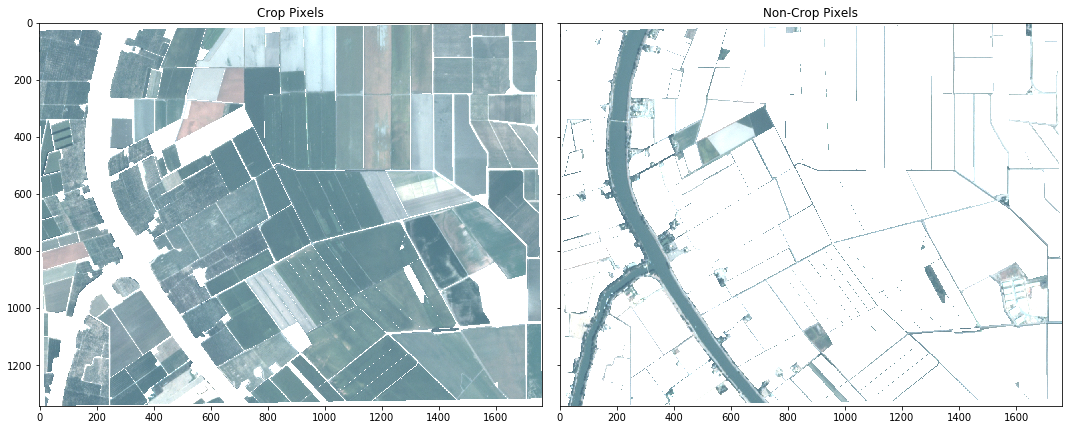

In [94]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, figsize=(15,15))
for ax in (ax1, ax2):
    ax.set_adjustable('box-forced')

ax1.imshow(bands_to_display(get_rgb(mask_contours(load_bands(train_pl_filename),
                                                  load_contours(train_ground_truth_filename,
                                                                train_pl_filename))),
                            alpha=True))
ax1.set_title('Crop Pixels')

ax2.imshow(bands_to_display(get_rgb(mask_contours(load_bands(train_pl_filename),
                                                  load_contours(train_ground_truth_filename,
                                                                train_pl_filename),
                                                  in_contours=True)),
                            alpha=True))
ax2.set_title('Non-Crop Pixels')
plt.tight_layout()

## Train KNN

KNN classification input is two datasets: X, a 2d array that provides the features to be classified on, and y, a 1d array that provides the classes. X and y are ordered along the first dimension.

http://scikit-learn.org/stable/auto_examples/neighbors/plot_classification.html#sphx-glr-auto-examples-neighbors-plot-classification-py

Prepare data

We need to take the non-crop and crop datasets above and transform into one X and y array. X is the band values for each pixel, y is the class of that pixel.

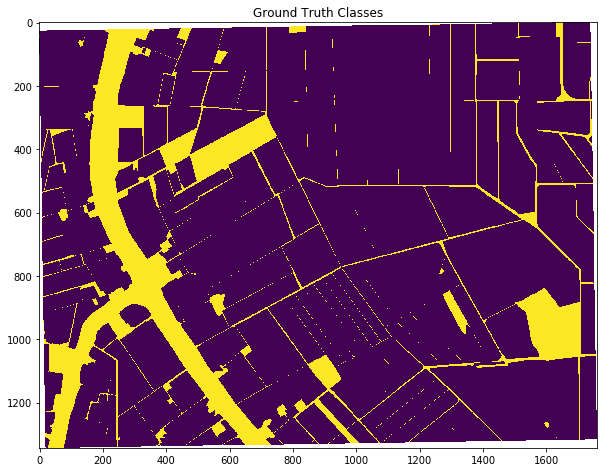

In [13]:
def classified_band_from_masks(band_mask, class_masks):
    class_band = np.zeros(band_mask.shape, dtype=np.uint8)

    for i, mask in enumerate(class_masks):
        class_band[~mask] = i

    # turn into masked array, using band_mask as mask
    return np.ma.array(class_band, mask=band_mask)


def create_contour_classified_band(pl_filename, ground_truth_filename):
    band_mask = load_bands(pl_filename)[0].mask
    contour_mask = _create_contour_mask(load_contours(ground_truth_filename, pl_filename),
                                        band_mask.shape)
    return classified_band_from_masks(band_mask, [contour_mask, ~contour_mask])

plt.figure(1, figsize=(10,10))
plt.imshow(create_contour_classified_band(train_pl_filename, train_ground_truth_filename))
plt.title('Ground Truth Classes')

Fit classifier on crop/non-crop pixels

In [14]:
def to_X(bands):
    """Convert to a list of pixel values, maintaining order and filtering out masked pixels."""
    return np.stack([b.compressed() for b in bands], axis=1)

def to_y(classified_band):
    return classified_band.compressed()

In [15]:
def fit_classifier(pl_filename, ground_truth_filename):
    n_neighbors = 15
    weights = 'uniform'
    clf = neighbors.KNeighborsClassifier(n_neighbors, weights=weights)
    
    train_class_band = create_contour_classified_band(pl_filename, ground_truth_filename)
    X = to_X(load_bands(pl_filename))
    y = to_y(train_class_band)
    clf.fit(X, y)
    return clf

clf = fit_classifier(train_pl_filename, train_ground_truth_filename)

Predict class for pixels in the same image

In [16]:
def classified_band_from_y(band_mask, y):
    class_band = np.ma.array(np.zeros(band_mask.shape),
                             mask=band_mask.copy())
    class_band[~class_band.mask] = y
    return class_band


def predict(pl_filename, clf):
    bands = load_bands(pl_filename)
    X = to_X(bands)

    y = clf.predict(X)
    
    return classified_band_from_y(bands[0].mask, y)

# it takes a while to run the prediction so cache the results
train_predicted_class_band = predict(train_pl_filename, clf)

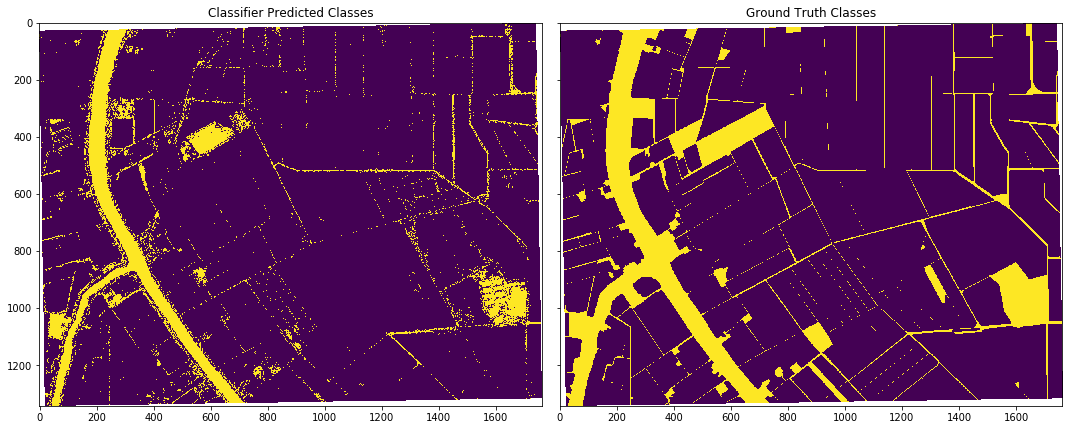

In [93]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, figsize=(15,15))
for ax in (ax1, ax2):
    ax.set_adjustable('box-forced')

ax1.imshow(train_predicted_class_band)
ax1.set_title('Classifier Predicted Classes')

ax2.imshow(create_contour_classified_band(train_pl_filename,
                                          train_ground_truth_filename))
ax2.set_title('Ground Truth Classes')
plt.tight_layout()

There is one region that was marked as a non-crop region in the ground truth data, but is not predicted to be a crop by the KNN classifier. Lets zoom into rows 200-600, columns 400-800 to take a look.

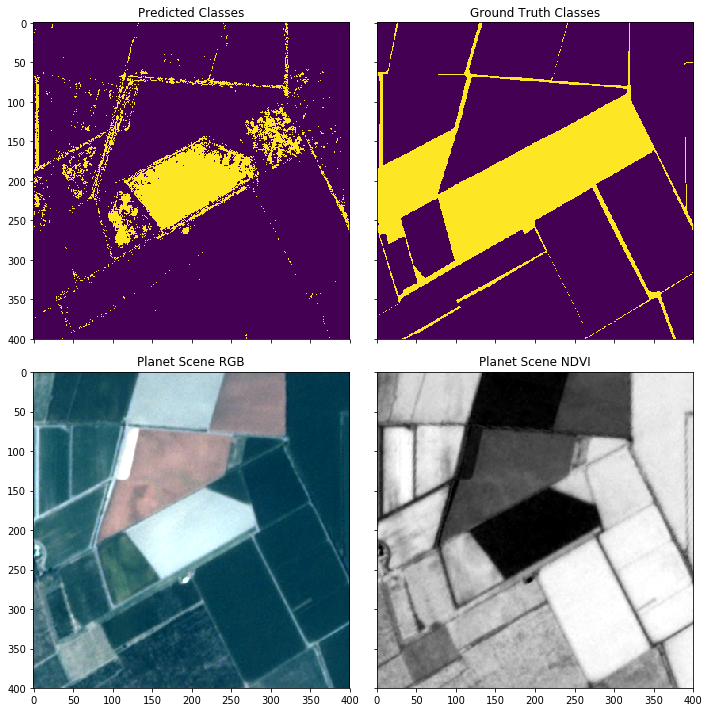

In [92]:
# x[1:10:5,::-1] is equivalent to 
# obj = (slice(1,10,5), slice(None,None,-1)); x[obj]
# https://docs.scipy.org/doc/numpy/reference/arrays.indexing.html
test_region = (slice(200,600,None), slice(400,800,None))

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True, figsize=(10,10))
for ax in (ax1, ax2, ax3, ax4):
    ax.set_adjustable('box-forced')

ax1.imshow(train_predicted_class_band[test_region])
ax1.set_title('Predicted Classes')

ax2.imshow(create_contour_classified_band(train_pl_filename,
                                          train_ground_truth_filename)[test_region])

ax2.set_title('Ground Truth Classes')

img_bands = NamedBands(*[b[test_region] for b in load_bands(train_pl_filename)])

ax3.imshow(bands_to_display(get_rgb(img_bands)))
ax3.set_title('Planet Scene RGB')

ax4.imshow(bands_to_display(3*[calculate_ndvi(img_bands)], alpha=False))
ax4.set_title('Planet Scene NDVI')
plt.tight_layout()

Wow! In the Planet scene, we can see that the crop shape has changed between when the ground truth data was collected and when the Planet scene was collected. The class predicted by the KNN classifier is more accurate than the ground truth class.

# Test Data

Use the KNN classifier trained on the training data to predict the crop regions in the test data.

In [19]:
data_folder = os.path.join('data', 'test')

# Created in datasets-identify notebook
test_metadata_filename = os.path.join(data_folder, '20160831_180257_0e26_3B_AnalyticMS_metadata.xml')
assert os.path.isfile(test_metadata_filename)

# Created in datasets-prepare notebook
test_pl_filename = os.path.join(data_folder, '20160831_180257_0e26_3B_AnalyticMS_cropped.tif')
assert os.path.isfile(test_pl_filename)

test_ground_truth_filename = os.path.join(data_folder, 'ground-truth_cropped.geojson')
assert os.path.isfile(test_ground_truth_filename)

In [20]:
test_predicted_class_band = predict(test_pl_filename, clf)

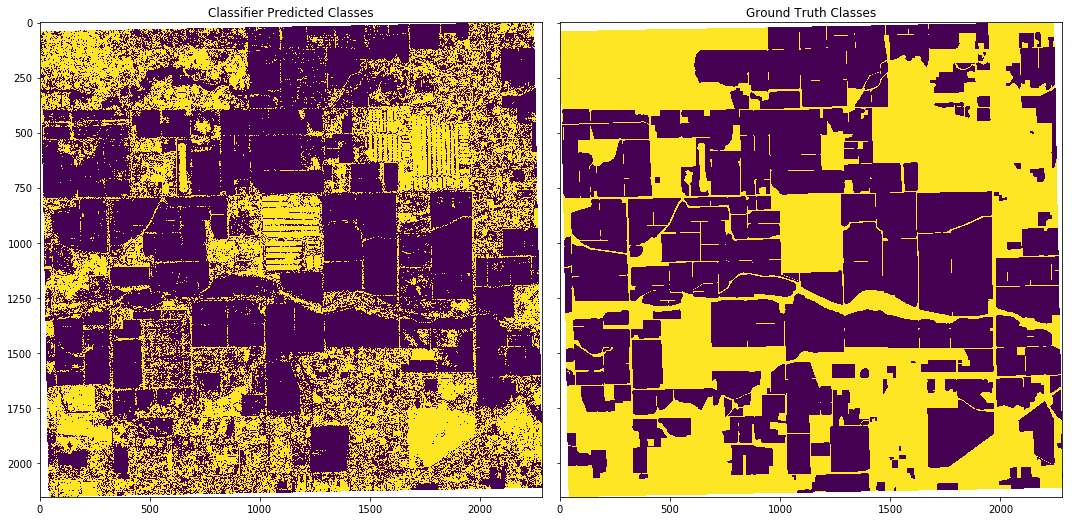

In [88]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, figsize=(15,15))
for ax in (ax1, ax2):
    ax.set_adjustable('box-forced')

ax1.imshow(test_predicted_class_band)
ax1.set_title('Classifier Predicted Classes')

ax2.imshow(create_contour_classified_band(test_pl_filename,
                                          test_ground_truth_filename))
ax2.set_title('Ground Truth Classes')
plt.tight_layout()

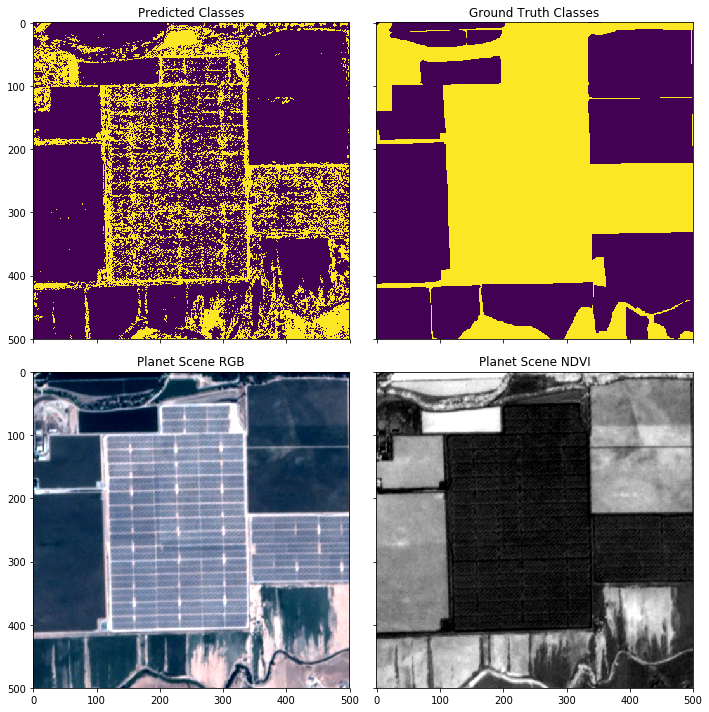

In [89]:
# x[1:10:5,::-1] is equivalent to 
# obj = (slice(1,10,5), slice(None,None,-1)); x[obj]
# https://docs.scipy.org/doc/numpy/reference/arrays.indexing.html
test_region = (slice(1250,1750,None), slice(350,850,None))

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True, figsize=(10,10))
for ax in (ax1, ax2, ax3, ax4):
    ax.set_adjustable('box-forced')

ax1.imshow(test_predicted_class_band[test_region])
ax1.set_title('Predicted Classes')

ax2.imshow(create_contour_classified_band(test_pl_filename,
                                          test_ground_truth_filename)[test_region])

ax2.set_title('Ground Truth Classes')

img_bands = NamedBands(*[b[test_region] for b in load_bands(test_pl_filename)])

ax3.imshow(bands_to_display(get_rgb(img_bands)))
ax3.set_title('Planet Scene RGB')

ax4.imshow(bands_to_display(3*[calculate_ndvi(img_bands)], alpha=False))
ax4.set_title('Planet Scene NDVI')
plt.tight_layout()

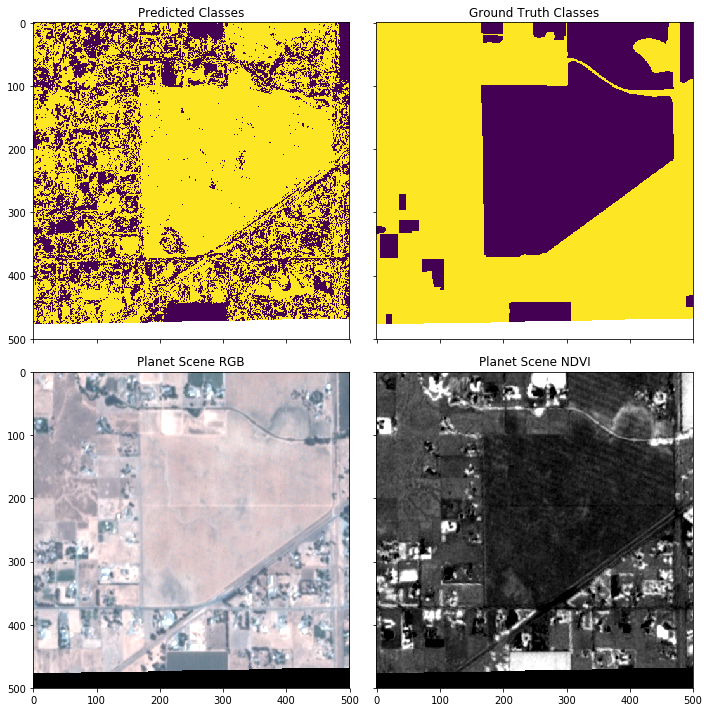

In [91]:
# x[1:10:5,::-1] is equivalent to 
# obj = (slice(1,10,5), slice(None,None,-1)); x[obj]
# https://docs.scipy.org/doc/numpy/reference/arrays.indexing.html
test_region = (slice(1650,2150,None), slice(1500,2000,None))

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True, figsize=(10,10))
for ax in (ax1, ax2, ax3, ax4):
    ax.set_adjustable('box-forced')

ax1.imshow(test_predicted_class_band[test_region])
ax1.set_title('Predicted Classes')

ax2.imshow(create_contour_classified_band(test_pl_filename,
                                          test_ground_truth_filename)[test_region])
ax2.set_title('Ground Truth Classes')



img_bands = NamedBands(*[b[test_region] for b in load_bands(test_pl_filename)])

ax3.imshow(bands_to_display(get_rgb(img_bands)))
ax3.set_title('Planet Scene RGB')

ax4.imshow(bands_to_display(3*[calculate_ndvi(img_bands)], alpha=False))
ax4.set_title('Planet Scene NDVI')
plt.tight_layout()